<div class="alert alert-block alert-success">
     
# IC PCDA CAPSTONE - HARRY BAKHSHI - NOTEBOOK 4 - VARIABLE SEASONAL DECOMPOSITION
     
</div>

MIT License for code used from https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python in notebook:   
https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python?tab=MIT-1-ov-file     

(Accessed 06/06/2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
import statsmodels.api as sm
import pickle
import statistics

In [2]:
#!pip install kaleido
#!pip install matrixprofile-ts

# Find variable seasons for imputation:

## Set up function for formatting plots:

Load timeseries:

In [3]:
#timeseries:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_ts_df_parallel.pik'
# with open(file, 'wb') as f:
#     pickle.dump(ts_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     ts_df = pickle.load(f) #load pickle file 'file' into variable
import pandas.api.types as ptypes
ptypes.is_datetime64_dtype(ts_df['timestamp'])
#^https://stackoverflow.com/questions/25043620/correct-way-to-check-if-pandas-dataframe-index-is-a-certain-type-datetimeindex
#Accessed 06/06/2024
ts_df_2 = ts_df.copy()
ts_df_orig = ts_df
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Columns: 11958 entries, timestamp to 8094_545621percent_display
dtypes: datetime64[ns](1), float64(11957)
memory usage: 11.9 MB


In [4]:
ts_df.tail(60)

timestamp  9984_679023median_total_price  9984_245338median_total_price  \
70  2012-05-22                            0.0                            0.0   
71  2012-05-29                            0.0                            0.0   
72  2012-06-02                            0.0                            0.0   
73  2012-06-03                            0.0                            0.0   
74  2012-06-11                            0.0                            0.0   
75  2012-06-19                            0.0                            0.0   
76  2012-06-26                            0.0                            0.0   
77  2012-07-08                            0.0                            0.0   
78  2012-07-17                            0.0                            0.0   
79  2012-07-24                            0.0                            0.0   
80  2012-07-31                            0.0                            0.0   
81  2012-08-05                            0.0                            0.0   
82  2012-08-14                            0.0                            0.0   
83  2012-08-21                            0.0                            0.0   
84  2012-08-28                            0.0                            0.0   
85  2012-09-01                            0.0                            0.0   
86  2012-09-10                            0.0                            0.0   
87  2012-09-18                            0.0                            0.0   
88  2012-09-25                            0.0                            0.0   
89  2012-10-04                            0.0                            0.0   
90  2012-10-07                            0.0                            0.0   
91  2012-10-16                            0.0                            0.0   
92  2012-10-23                            0.0                            0.0   
93  2012-10-30                            0.0                            0.0   
94  2012-11-09                            0.0                            0.0   
95  2012-11-12                            0.0                            0.0   
96  2012-11-13                            0.0                            0.0   
97  2012-11-20                            0.0                            0.0   
98  2012-11-27                            0.0                            0.0   
99  2012-12-06                            0.0                            0.0   
100 2012-12-18                            0.0                            0.0   
101 2012-12-25                            0.0                            0.0   
102 2013-01-01                            0.0                            0.0   
103 2013-01-15                            0.0                            0.0   
104 2013-01-22                            0.0                            0.0   
105 2013-01-29                            0.0                            0.0   
106 2013-02-04                            0.0                            0.0   
107 2013-02-07                            0.0                            0.0   
108 2013-02-19                            0.0                            0.0   
109 2013-02-26                            0.0                            0.0   
110 2013-03-19                            0.0                            0.0   
111 2013-03-26                            0.0                            0.0   
112 2013-04-06                            0.0                            0.0   
113 2013-04-16                            0.0                            0.0   
114 2013-04-23                            0.0                            0.0   
115 2013-04-30                            0.0                            0.0   
116 2013-05-02                            0.0                            0.0   
117 2013-05-03                            0.0                            0.0   
118 2013-05-14                            0.0                            0.0   
119 2

Create function for formatting plotly plots:

In [5]:
#For formatting plots:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", figsize=(500,900), font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

Create seasonality terms:

In [6]:
#Create seasonality terms:
ts_df = ts_df.set_index("timestamp")
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year
#Making ordered categoricals to make for sorted plots
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
ts_df.head(60)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

9984_679023median_total_price  9984_245338median_total_price  \
timestamp                                                                  
2011-01-08                       180.2625                       469.5375   
2011-01-17                         0.0000                         0.0000   
2011-01-24                         0.0000                         0.0000   
2011-01-31                         0.0000                         0.0000   
2011-02-05                         0.0000                         0.0000   
2011-02-14                         0.0000                         0.0000   
2011-02-21                         0.0000                         0.0000   
2011-02-28                         0.0000                         0.0000   
2011-03-10                         0.0000                         0.0000   
2011-03-14                         0.0000                         0.0000   
2011-03-21                         0.0000                         0.0000   
2011-03-28                         0.0000                         0.0000   
2011-04-04                         0.0000                         0.0000   
2011-04-07                         0.0000                         0.0000   
2011-04-18                         0.0000                         0.0000   
2011-04-25                         0.0000                         0.0000   
2011-05-09                         0.0000                         0.0000   
2011-05-12                         0.0000                         0.0000   
2011-05-16                         0.0000                         0.0000   
2011-05-23                         0.0000                         0.0000   
2011-05-30                         0.0000                         0.0000   
2011-06-06                         0.0000                         0.0000   
2011-06-13                         0.0000                         0.0000   
2011-06-20                         0.0000                         0.0000   
2011-06-27                         0.0000                         0.0000   
2011-07-02                         0.0000                         0.0000   
2011-07-03                         0.0000                         0.0000   
2011-07-11                         0.0000                         0.0000   
2011-07-18                         0.0000                         0.0000   
2011-07-25                         0.0000                         0.0000   
2011-08-08                         0.0000                         0.0000   
2011-08-15                         0.0000                         0.0000   
2011-08-22                         0.0000                         0.0000   
2011-08-29                         0.0000                         0.0000   
2011-09-05                         0.0000                         0.0000   
2011-09-19                         0.0000                         0.0000   
2011-09-26                         0.0000                         0.0000   
2011-10-10                         0.0000                         0.0000   
2011-10-17                         0.0000                         0.0000   
2011-10-24                         0.0000                         0.0000   
2011-10-31                         0.0000                         0.0000   
2011-11-04                         0.0000                         0.0000   
2011-11-07                         0.0000                         0.0000   
2011-11-14                         0.0000                         0.0000   
2011-11-21                         0.0000                         0.0000   
2011-11-28                         0.0000                         0.0000   
2011-12-09                         0.0000                         0.0000   
2011-12-12                         0.0000                         0.0000   
2011-12-19                         0.0000                         0.0000   
2011-12-26                         0.0000                         0.0000   
2012-01-05                         0.0000                   

In [7]:
ts_df['9984_245387percent_featured']

timestamp
2011-01-08    0.0
2011-01-17    0.0
2011-01-24    0.0
2011-01-31    0.0
2011-02-05    0.0
             ... 
2013-09-04    0.0
2013-09-07    0.0
2013-11-06    0.0
2013-12-02    0.0
2013-12-03    0.0
Name: 9984_245387percent_featured, Length: 130, dtype: float64

Import libraries for multi-seasonal decomposition:

In [8]:
#Import libraries for multi-seasonal decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [9]:
col_list = list(ts_df.columns.values[:10640])
print(col_list)

['9984_679023median_total_price', '9984_245338median_total_price', '9984_222087median_total_price', '9984_223153median_total_price', '9984_223245median_total_price', '9984_222765median_total_price', '9984_547934median_total_price', '9984_378934median_total_price', '9984_219029median_total_price', '9984_216418median_total_price', '9984_219009median_total_price', '9984_217390median_total_price', '9984_216233median_total_price', '9984_216425median_total_price', '9984_320485median_total_price', '9984_300021median_total_price', '9984_245387median_total_price', '9984_216419median_total_price', '9984_398721median_total_price', '9984_217217median_total_price', '9984_217777median_total_price', '9984_219844median_total_price', '9984_600934median_total_price', '9984_673209median_total_price', '9984_327492median_total_price', '9984_300291median_total_price', '9984_546789median_total_price', '9984_545621median_total_price', '9954_679023median_total_price', '9954_245338median_total_price', '9954_222

Can create series for each variable:

In [10]:
# numeric variables:
# median_total_price = median sales price for all product retailings in all stores (numeric, float)               
# median_base_price = median base price for all product retailings in all stores (numeric, float)
# median_units_sold = median total units sold for all product retailings in all stores (numeric, stored as float, but
#only integer)
# percent_featured = percent of retailings of products in all stores recorded where products were featured 
#(numeric, float)
# percent_display = percent of retailings of products in all stores recorded where products were displayed 
#prominently in store (numeric, float)
for var in range(len(col_list)):
    globals()[("ts_" + str(col_list[var]))] = ts_df[col_list[var]]
#^https://stackoverflow.com/questions/19300174/how-to-assign-each-element-of-a-list-to-a-separate-variable
#Accessed 11/06/2024

In [11]:
ts_9984_679023median_total_price

timestamp
2011-01-08    180.2625
2011-01-17      0.0000
2011-01-24      0.0000
2011-01-31      0.0000
2011-02-05      0.0000
                ...   
2013-09-04      0.0000
2013-09-07      0.0000
2013-11-06      0.0000
2013-12-02      0.0000
2013-12-03      0.0000
Name: 9984_679023median_total_price, Length: 130, dtype: float64

In [12]:
ts_9984_545621percent_display

timestamp
2011-01-08    0.0
2011-01-17    0.0
2011-01-24    0.0
2011-01-31    0.0
2011-02-05    0.0
             ... 
2013-09-04    0.0
2013-09-07    0.0
2013-11-06    0.0
2013-12-02    0.0
2013-12-03    0.0
Name: 9984_545621percent_display, Length: 130, dtype: float64

# VARIABLE MULTI-SEASONAL DECOMPOSITION USING FOURIER DECOMPOSITION

* Use Fourier terms over STL method because this is "robust to outliers" when "doing regularized regression using the Fourier terms on the signal", "decoupling the resolution of the data and the expected seasonality".     

^Source: Modern Time Series Forecasting with Python (Manu Joseph, 2022)


Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:

Make custom seasonality term using "month" and "week_of_month" (poor seasonality with "year" also included):

In [13]:
#Making custom seasonality term
ts_df["week_of_month"] = pd.Series(np.zeros(len(ts_df)), index=ts_df.index)
from math import ceil
def get_week_of_month(date):
   first_day = date.replace(day=1)

   day_of_month = date.day

   if(first_day.weekday() == 6):
       adjusted_dom = day_of_month + ((1 + first_day.weekday()) / 7)
   else:
       adjusted_dom = day_of_month + first_day.weekday()

   return int(ceil(adjusted_dom/7.0))
#^https://stackoverflow.com/questions/3806473/week-number-of-the-month/26662038#26662038
#Accessed 10/06/2024
for row in range(len(ts_df_2)):
    ts_df["week_of_month"][row] = get_week_of_month(ts_df_2['timestamp'][row])
#Creating a sorted unique combination df
map_df = ts_df[["month", "week_of_month"]].drop_duplicates().sort_values(["month", "week_of_month"])
# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)
# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["month", "week_of_month"], how='left', validate="many_to_one")['map']
seasonality = seasonality.to_numpy(seasonality)
seasonality
# #^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
# #Accessed 06/06/2024

/tmp/ipykernel_68386/1785069018.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df["week_of_month"][row] = get_week_of_month(ts_df_2['timestamp'][row])
/tmp/ipykernel_68386/1785069018.py:18: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ts_df["week_of_month"][row] = get_week_of_month(ts_df_2['timestamp'][row])


array([ 2,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 18, 18, 20, 21, 23,
       23, 24, 25, 26, 28, 29, 30, 31, 32, 32, 34, 35, 36, 38, 39, 40, 41,
       43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61,  1,
        3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 18, 19, 20,
       22, 24, 25, 26, 27, 27, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41,
       42, 44, 45, 46, 47, 47, 48, 49, 50, 53, 54, 54, 55, 56, 58, 60, 61,
        1,  3,  4,  5,  8,  8, 10, 11, 15, 16, 17, 19, 20, 21, 22, 22, 24,
       25, 26, 30, 31, 32, 37, 42, 43, 53, 57, 57])

## Fitting the decomposition object for all variables

***Ran for each variable in col_list (list of the variables)***

In [14]:
seasonal_period_list = []

In [15]:
round((32/(900))*130) #size of sub-sequences to compare for conserved features in time - github example used 32 for sequence of 
#approx. length 900 = 32/900

5

Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model - one variable as an example:

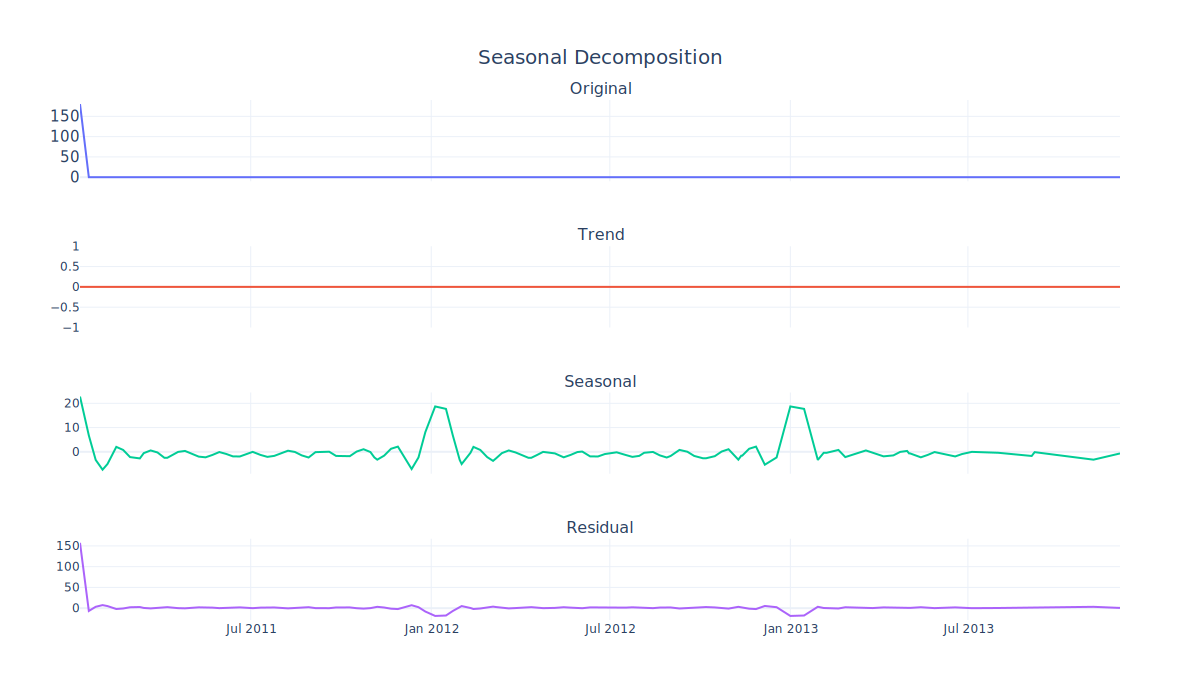

52

In [16]:
#Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:
#For first variable:
stl = FourierDecomposition(model = "additive", n_fourier_terms=10)
res_ts_9984_679023median_total_price = stl.fit(ts_9984_679023median_total_price, seasonality=seasonality)
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_initial_parallel/multi_seasonal_decomposition_fit_'
file_edit = file
file_to_use = file_edit + '9984_679023median_total_price' + '_initial' + '.pik'
with open(file_to_use, 'wb') as f:
   pickle.dump(res_ts_9984_679023median_total_price, f) #write df to .pik file on disk
#Calculate seasonal period:
from matrixprofile import *
pattern = res_ts_9984_679023median_total_price.seasonal
pattern = pattern.to_numpy()
m = 5 #size of sub-sequences to compare for conserved features
mp = matrixProfile.stomp(pattern, m)
for ele in range(len(list(mp[1]))):
    if mp[1][ele] == float('inf'):
        #https://www.geeksforgeeks.org/python-infinity/https://codedamn.com/news/python/how-to-represent-infinity-in-python#
        #Accessed 14/06/2024
        mp[1][ele] = 0
mtfs , motif_d  = motifs.motifs(pattern, mp, max_motifs=10)
#mtfs = list of lists where each list is a motif with the indices of where each instance of the motif begins
#motif_d = how conserved each motif is
for ele in range(len(mtfs)):
    if len(mtfs[ele]) >= 3: #need two complete cycles for imputation = 3 indices of conserved features from the repeating motif
        motif = motif_d.index(min(motif_d[:(ele + 1)])) #best motif_d = most conserved
        dist_list = []
        for instance in range(len(mtfs[motif]) - 1):
            inst_current = mtfs[motif][instance]
            inst_next = mtfs[motif][instance + 1]
            dist_timestamps = inst_next - inst_current
            dist_list.append(dist_timestamps)
        import math
        seasonal_per = math.ceil(statistics.median(dist_list)) #(typical value as a measure of central tendency for a skewed or symmeteric 
        #(median = mean (1)) distribution):    
        #^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1
        #if median results in a .5 want higher val as for seasonal interpolation only integers allowed and better for pattern
        #to repeat too slow in model rather than overestimate for prices, featuring, units sold, displaying
        seasonal_period_list.append(seasonal_per)
    else:
        seasonal_period_list.append('not seasonal')
#^https://stackoverflow.com/questions/49873443/repeated-patterns-in-time-series-graphs - learned of Matrix Profile method
#Accessed 14/06/2024
#^http://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf - understood principles of Matrix Profile method
#Accessed 14/06/2024
#^http://www.cs.ucr.edu/~eamonn/MatrixProfile.html - found link to python package implementing Matrix Profile method, matrixprofile-ts
#Accessed 14/06/2024
#^https://github.com/target/matrixprofile-ts/blob/master/docs/examples/Motif%20Discovery.ipynb , https://github.com/target/matrixprofile-ts/blob/master/matrixprofile/matrixProfile.py
#Found source code and adapted it for calculating seasonal period from identified motifs
#Accessed 14/06/2024
#Find unique seasons:
entry_list = seasonal_period_list
found_list = []
unique_list = []
entry = []
entry_list_length = len(seasonal_period_list)
for i in range(entry_list_length):
    entry = entry_list[i]
    if entry not in found_list:
        unique_list.append(entry)
        found_list.append(entry)
unique_list
loopcount = len(unique_list)
i = 0
while i < loopcount:
    #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
    #Accessed 03/06/2024
    var = unique_list[i]
    if isinstance(var, str) == True:
        #^https://pythonprinciples.com/blog/check-if-var-is-string/
        #Accessed 14/06/2024
        unique_list.remove(unique_list[i])
        loopcount = int(loopcount - 1)
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024
    i += 1
    #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
    #Accessed 03/06/2024  
if not unique_list:
    seasonal_per = 'not seasonal'
#^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
#Accessed 14/06/2024
else:
    for item in range(len(unique_list)):
        if unique_list[item] > (len(ts_df)/2): #need min observations for 2 cycles of the season to be valid
            del unique_list[item]
            #^https://note.nkmk.me/en/python-list-clear-pop-remove-del/#remove-items-by-index-or-slice-del
            #Accessed 23/06/2024
    if not unique_list:
        seasonal_per = 'not seasonal'
        #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
        #Accessed 14/06/2024
    else:
         seasonal_per = min(unique_list, key=lambda x: abs(x - 52))
        #^https://medium.com/devcodef1com/match-lists-based-on-the-closest-value-in-python-5a0234548188#:~:text=Approach%202%3A%20Using%20the%20min()%20Function&text=The%20lambda%20function%20calculates%20the,which%20is%20the%20closest%20value.
        #Accessed 29/06/2024
        #knowing variables aggregated by median for all products and stores that are seasonal have seasonal period of 52, 
        #choose season closest to 52 - interpolator function as defined from source code can only take a single integer seasonal period argument, see below
#- https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/495cd6275ca3f3fd9951348d63fc0020a0f43636/src/imputation/interpolation.py

#Plot:
fig = res_ts_9984_679023median_total_price.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_initial_parallel/multi_seasonal_decomposition_9984_679023median_total_price_initial.png")
fig.show(renderer="svg")
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
#Accessed 06/06/2024
seasonal_per

Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model for all variables:

In [17]:
seasonal_period_list = []

In [20]:
#Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:
import statistics
import time
start = time.time()
print('Start!')
# for var in range(1):
for var in range(len(col_list)):
    ts = globals()[("ts_" + str(col_list[var]))]
    ts = ts_df[col_list[var]]
    stl = FourierDecomposition(model = "additive", n_fourier_terms=10) 
    res_var = stl.fit(ts, seasonality=seasonality)
    file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_initial_parallel/multi_seasonal_decomposition_fit_'
    file_edit = file
    file_to_use = file_edit + str(col_list[var]) + '_initial' + '.pik'
    with open(file_to_use, 'wb') as f:
       pickle.dump(res_var, f) #write df to .pik file on disk
    #Calculate seasonal period:
    from matrixprofile import *
    pattern = res_var.seasonal
    pattern = pattern.to_numpy()
    m = 5 #size of sub-sequences to compare for conserved features
    mp = matrixProfile.stomp(pattern, m)
    seasonal_periods_list = []
    for ele in range(len(list(mp[1]))):
        if mp[1][ele] == float('inf'):
            #https://www.geeksforgeeks.org/python-infinity/https://codedamn.com/news/python/how-to-represent-infinity-in-python#
            #Accessed 14/06/2024
            mp[1][ele] = 0
    mtfs , motif_d  = motifs.motifs(pattern, mp, max_motifs=10)
    #mtfs = list of lists where each list is a motif with the indices of where each instance of the motif begins
    #motif_d = how conserved each motif is
    for ele in range(len(mtfs)):
        if len(mtfs[ele]) >= 3: #need two complete cycles for imputation = 3 indices of conserved features from the repeating motif
            motif = motif_d.index(min(motif_d[:(ele + 1)])) #best motif_d = most conserved
            dist_list = []
            for instance in range(len(mtfs[motif]) - 1):
                inst_current = mtfs[motif][instance]
                inst_next = mtfs[motif][instance + 1]
                dist_timestamps = inst_next - inst_current
                dist_list.append(dist_timestamps)
            import math
            seasonal_per = math.ceil(statistics.median(dist_list)) #(typical value as a measure of central tendency for a skewed or symmeteric 
            #(median = mean (1)) distribution):    
            #^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1
            #if median results in a .5 want higher val as for seasonal interpolation only integers allowed and better for pattern
            #to repeat too slow in model rather than overestimate for prices, featuring, units sold, displaying
            seasonal_periods_list.append(seasonal_per)
        else:
            seasonal_periods_list.append('not seasonal')
    #^https://stackoverflow.com/questions/49873443/repeated-patterns-in-time-series-graphs - learned of Matrix Profile method
    #Accessed 14/06/2024
    #^http://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf - understood principles of Matrix Profile method
    #Accessed 14/06/2024
    #^http://www.cs.ucr.edu/~eamonn/MatrixProfile.html - found link to python package implementing Matrix Profile method, matrixprofile-ts
    #Accessed 14/06/2024
    #^https://github.com/target/matrixprofile-ts/blob/master/docs/examples/Motif%20Discovery.ipynb , https://github.com/target/matrixprofile-ts/blob/master/matrixprofile/matrixProfile.py
    #Found source code and adapted it for calculating seasonal period from identified motifs
    #Accessed 14/06/2024
    #Find unique seasons:
    entry_list = seasonal_periods_list
    found_list = []
    unique_list = []
    entry = []
    entry_list_length = len(seasonal_periods_list)
    for i in range(entry_list_length):
        entry = entry_list[i]
        if entry not in found_list:
            unique_list.append(entry)
            found_list.append(entry)
    unique_list
    loopcount = len(unique_list)
    i = 0
    while i < loopcount:
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024
        entry_2 = unique_list[i]
        if isinstance(entry_2, str) == True:
            #^https://pythonprinciples.com/blog/check-if-var-is-string/
            #Accessed 14/06/2024
            unique_list.remove(unique_list[i])
            loopcount = int(loopcount - 1)
            #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
            #Accessed 03/06/2024
        i += 1
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024  
    if not unique_list:
        seasonal_per = 'not seasonal'
    #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
    #Accessed 14/06/2024
    else:
        for item in range(len(unique_list)):
            if unique_list[item] > (len(ts_df)/2): #need min observations for 2 cycles of the season to be valid
                del unique_list[item]
                #^https://note.nkmk.me/en/python-list-clear-pop-remove-del/#remove-items-by-index-or-slice-del
                #Accessed 23/06/2024
        if not unique_list:
            seasonal_per = 'not seasonal'
            #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
            #Accessed 14/06/2024
        else:
             seasonal_per = min(unique_list, key=lambda x: abs(x - 52))
        #^https://medium.com/devcodef1com/match-lists-based-on-the-closest-value-in-python-5a0234548188#:~:text=Approach%202%3A%20Using%20the%20min()%20Function&text=The%20lambda%20function%20calculates%20the,which%20is%20the%20closest%20value.
        #Accessed 29/06/2024
        #knowing variables aggregated by median for all products and stores that are seasonal have seasonal period of 52, 
        #choose season closest to 52 - interpolator function as defined from source code can only take a single integer seasonal period argument, see below
    #- https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/495cd6275ca3f3fd9951348d63fc0020a0f43636/src/imputation/interpolation.py

    seasonal_period_list.append(seasonal_per)
    
    fig = res_var.plot(interactive=True)
    fig.update_layout(
                legend=dict(
                    font=dict(size=15),
                    orientation="h",
                    yanchor="bottom",
                    y=0.98,
                    xanchor="right",
                    x=1,
                ),
                yaxis=dict(
                    # title_text=ylabel,
                    titlefont=dict(size=15),
                    tickfont=dict(size=15),
                ),
                xaxis=dict(
                    # title_text=xlabel,
                    titlefont=dict(size=15),
                    tickfont=dict(size=15),
                )
            )
    #^https://www.datacamp.com/tutorial/python-append-string#
    #Accessed 12/06/2024
    file_2 = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_initial_parallel/multi_seasonal_decomposition_'
    file_edit_2 = file_2
    file_to_use_2 = file_edit_2 + str(col_list[var]) + '_initial' + '.png'
    fig.write_image(file_to_use_2)
    #^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
    #Accessed 06/06/2024
end = time.time()
print('secs: ', end - start) # time in seconds
print('min: ', (end - start)/60) # time in min

Start!


/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in 

secs:  837.6098577976227
min:  13.960164296627045


/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in divide



In [21]:
seasonal_period_list_init = seasonal_period_list
seasonal_period_list_init

[52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 'not se

# Create complete timeseries dataframe and impute missing values

Add missing rows for October 2013:

In [239]:
import datetime
ts_df['timestamp'] = ts_df.index
first_column = ts_df.pop('timestamp') 
# insert column using insert(position,column_name, 
# first_column) function 
ts_df.insert(0, 'timestamp', first_column)
#^https://www.geeksforgeeks.org/how-to-move-a-column-to-first-position-in-pandas-dataframe/
#Accessed 24/06/2024
ts_df = ts_df.set_index(np.arange(0, len(ts_df)))
drop_list = ts_df.columns.values[10641:]
ts_df = ts_df.drop(drop_list, axis=1)
new_row_data = []
for i in range(10641):
    new_row_data.append(np.nan)
    #^https://www.analyticsvidhya.com/blog/2023/12/supercharge-your-dataframes-mastering-row-appending-in-pandas/#:~:text=The%20append()%20function%20in,for%20beginners%20and%20seasoned%20professionals.&text=While%20this%20method%20is%20simple,multiple%20rows%20in%20a%20loop
    #Accessed 04/06/2024
print(new_row_data)
print(len(new_row_data))
timestamp = '09/07/2013'
index_list = []
for date in range(7):
    timestamp = pd.to_datetime(timestamp) + pd.DateOffset(days=7)
    index_list.insert(date, timestamp)
#^https://stackoverflow.com/questions/6871016/adding-days-to-a-date-in-python
#Accessed 09/06/2024
print(index_list)
from pandas import DataFrame, concat
for row in range(7):
    line = DataFrame(np.array([new_row_data]), columns=ts_df.columns.values)
    ts_df = concat([ts_df.iloc[:126 + row + 1], line, ts_df.iloc[row + 126 + 1:]]).reset_index(drop=True)
    #^https://stackoverflow.com/questions/15888648/is-it-possible-to-insert-a-row-at-an-arbitrary-position-in-a-dataframe-using-pan
    #Accessed 03/06/2024
    ts_df.loc[row + 126 + 1, ts_df.columns.values[0]] = index_list[row]
print(ts_df.tail(60))

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
141
[Timestamp('2013-09-14 00:00:00'), Timestamp('2013-09-21 00:00:00'), Timestamp('2013-09-28 00:00:00'), Timestamp('2013-10-05 00:00:00'), Timestamp('2013-10-12 00:00:00'), Timestamp('2013-10-19 00:00:00'), Timestamp('2013-10-26 00:00:00')]
     timestamp  679023median_total_price  245338med

/tmp/ipykernel_50932/2806510670.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_50932/2806510670.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_50932/2806510670.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operati

Create seasonality terms:

In [240]:
#Create seasonality terms:
ts_df = ts_df.set_index("timestamp")
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year
#Making ordered categoricals to make for sorted plots
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
ts_df.head(60)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

679023median_total_price  245338median_total_price  \
timestamp                                                        
2011-01-08                  180.2625                 469.53750   
2011-01-17                  178.1250                 426.78750   
2011-01-24                  178.1250                 426.78750   
2011-01-31                  178.1250                 448.16250   
2011-02-05                  205.9125                 469.53750   
2011-02-14                  205.9125                 453.15000   
2011-02-21                  205.9125                 455.28750   
2011-02-28                  205.9125                 455.28750   
2011-03-10                  178.1250                 318.84375   
2011-03-14                  205.9125                 426.78750   
2011-03-21                  177.4125                 426.78750   
2011-03-28                  177.4125                 426.78750   
2011-04-04                  177.4125                 391.16250   
2011-04-07                  204.4875                 469.53750   
2011-04-18                  205.9125                 463.12500   
2011-04-25                  205.9125                 469.53750   
2011-05-09                  208.7625                 469.53750   
2011-05-12                  213.0375                 391.16250   
2011-05-16                  205.9125                 469.53750   
2011-05-23                  205.9125                 469.53750   
2011-05-30                  205.9125                 370.85625   
2011-06-06                  201.6375                 367.29375   
2011-06-13                  178.1250                 454.21875   
2011-06-20                  178.1250                 469.53750   
2011-06-27                  178.1250                 469.53750   
2011-07-02                  178.1250                 448.16250   
2011-07-03                  205.9125                 448.16250   
2011-07-11                  177.4125                 469.53750   
2011-07-18                  213.0375                 355.53750   
2011-07-25                  177.4125                 469.53750   
2011-08-08                  177.4125                 469.53750   
2011-08-15                  213.0375                 469.53750   
2011-08-22                  213.0375                 469.53750   
2011-08-29                  213.0375                 469.53750   
2011-09-05                  205.9125                 469.53750   
2011-09-19                  178.1250                 469.53750   
2011-09-26                  178.1250                 319.91250   
2011-10-10                  205.9125                 319.55625   
2011-10-17                  213.0375                 318.48750   
2011-10-24                  213.0375                 469.53750   
2011-10-31                  204.4875                 469.53750   
2011-11-04                  205.9125                 391.16250   
2011-11-07                  213.0375                 355.53750   
2011-11-14                  178.8375                 469.53750   
2011-11-21                  177.4125                 391.16250   
2011-11-28                  213.0375                 391.16250   
2011-12-09                  178.1250                 469.53750   
2011-12-12                  213.0375                 469.53750   
2011-12-19                  213.0375                 469.53750   
2011-12-26                  213.0375                 469.53750   
2012-01-05                  213.0375                 469.53750   
2012-01-16                  213.0375                 469.53750   
2012-01-23                  213.0375                 469.53750   
2012-01-30                  213.0375                 355.53750   
2012-02-01                  213.0375                 469.53750   
2012-02-10                  213.0375                 355.53750   
2012-02-13                  177.4125                 469.53750   
2012-02-20                  177.4125                 469.53750   
2012-02-27                  213.0375                

In [241]:
#print(ts_df.tail(50))

Using darts for forecasting (see notebook 6) can't infer or set (as values missing) freq of the time index as the date indices are inconsistent (there are 3 frequencies: '8D' (every 8 calendar days), 'W-MON' (weekly beginning on Monday), 'B' (every business day). As W-MON dominant freq of the actual timestamps, keep W-MON records and impute other values to make 148 timestamps seperated in W-MON frequency, based on the seasonality of the actual (date-index inconsistent) data if seasonal (if not seasonal impute with the median as a heuristic (typical value as a measure of central tendency for a skewed or symmeteric (median = mean (1)) distribution)):  
- Impute seasonal data with seasonal period, negative imputed values with the median as a heuristic, percent values > 1 with the median as a heuristic (typical value as a measure of central tendency for a skewed or symmeteric (median = mean (1)) distribution)       
^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1    
Accessed 13/06/2024  

In [242]:
ts_df_2 = ts_df.copy()

### See below - add missing dates (not with a diff of 7 see below) to infer freq as W-MON:

In [243]:
ts_df_2['timestamp'] = ts_df_2.index
ts_df_2.set_index(np.arange(0, len(ts_df_2)))

679023median_total_price  245338median_total_price  \
0                    180.2625                  469.5375   
1                    178.1250                  426.7875   
2                    178.1250                  426.7875   
3                    178.1250                  448.1625   
4                    205.9125                  469.5375   
..                        ...                       ...   
132                       NaN                       NaN   
133                       NaN                       NaN   
134                  234.4125                  375.4875   
135                  177.4125                  355.5375   
136                  177.4125                  339.8625   

     222087median_total_price  223153median_total_price  \
0                   226.93125                  213.0375   
1                   196.65000                  190.2375   
2                   190.23750                  190.2375   
3                   226.93125                  212.3250   
4                   227.28750                  213.0375   
..                        ...                       ...   
132                       NaN                       NaN   
133                       NaN                       NaN   
134                 203.77500                  235.8375   
135                 195.58125                  177.4125   
136                 210.18750                  235.8375   

     223245median_total_price  222765median_total_price  \
0                    205.2000                  195.2250   
1                    205.9125                  240.8250   
2                    213.0375                  240.8250   
3                    213.0375                  240.8250   
4                    213.0375                  234.4125   
..                        ...                       ...   
132                       NaN                       NaN   
133                       NaN                       NaN   
134                  223.7250                  239.4000   
135                  213.7500                  227.2875   
136                  227.2875                  227.2875   

     547934median_total_price  378934median_total_price  \
0                    177.4125                  205.9125   
1                    177.4125                  177.4125   
2                    177.4125                  177.4125   
3                    177.4125                  177.4125   
4                    142.5000                  177.4125   
..                        ...                       ...   
132                       NaN                       NaN   
133                       NaN                       NaN   
134                  177.4125                  205.9125   
135                  177.4125                  155.3250   
136                  177.4125                  205.9125   

     219029median_total_price  216418median_total_price  ...  \
0                    312.7875                  87.63750  ...   
1                    312.0750                  93.33750  ...   
2                    312.7875                  85.50000  ...   
3                    312.7875                  84.07500  ...   
4                    312.7875                  87.63750  ...   
..                        ...                       ...  ...   
132                       NaN                       NaN  ...   
133                       NaN                       NaN  ...   
134                  327.0375                  97.25625  ...   
135                  312.7875                  88.70625  ...   
136                  327.0375                  89.06250  ...   

     545621percent_display  weekday_name  weekday  week  day        date  \
0                      0.0      Saturday        5     1    8  2011-01-08   
1                      0.0        Monday        0     3   17  2011-01-17   
2                      0.0        Monday        0     4   24  2011-01-24   
3                      0.0        Monday        0     5   31  2011-01-31   
4                   

In [244]:
import statistics
diff_dict = {}
count = 0
count_2 = 0
for row in range(len(ts_df_2['timestamp']) - 1):
    d1 = ts_df_2['timestamp'][row]
    d2 = ts_df_2['timestamp'][row + 1]
    diff_dict[(row + 1)] = abs((d2 - d1).days)
    if diff_dict[(row + 1)] == 9:
        count += 1
    if diff_dict[(row + 1)] == 7:
        count_2 += 1
print(diff_dict)
print(statistics.mode(list(diff_dict.values())))
print(min(list(diff_dict.values())))
print(count)
print(count_2)

{1: 9, 2: 7, 3: 7, 4: 5, 5: 9, 6: 7, 7: 7, 8: 10, 9: 4, 10: 7, 11: 7, 12: 7, 13: 3, 14: 11, 15: 7, 16: 14, 17: 3, 18: 4, 19: 7, 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 5, 26: 1, 27: 8, 28: 7, 29: 7, 30: 14, 31: 7, 32: 7, 33: 7, 34: 7, 35: 14, 36: 7, 37: 14, 38: 7, 39: 7, 40: 7, 41: 4, 42: 3, 43: 7, 44: 7, 45: 7, 46: 11, 47: 3, 48: 7, 49: 7, 50: 10, 51: 11, 52: 7, 53: 7, 54: 2, 55: 9, 56: 3, 57: 7, 58: 7, 59: 6, 60: 3, 61: 6, 62: 7, 63: 7, 64: 13, 65: 3, 66: 5, 67: 7, 68: 12, 69: 9, 70: 7, 71: 7, 72: 4, 73: 1, 74: 8, 75: 8, 76: 7, 77: 12, 78: 9, 79: 7, 80: 7, 81: 5, 82: 9, 83: 7, 84: 7, 85: 4, 86: 9, 87: 8, 88: 7, 89: 9, 90: 3, 91: 9, 92: 7, 93: 7, 94: 10, 95: 3, 96: 1, 97: 7, 98: 7, 99: 9, 100: 12, 101: 7, 102: 7, 103: 14, 104: 7, 105: 7, 106: 6, 107: 3, 108: 12, 109: 7, 110: 21, 111: 7, 112: 11, 113: 10, 114: 7, 115: 7, 116: 2, 117: 1, 118: 11, 119: 7, 120: 7, 121: 21, 122: 7, 123: 10, 124: 27, 125: 34, 126: 3, 127: 7, 128: 7, 129: 7, 130: 7, 131: 7, 132: 7, 133: 7, 134: 11, 135: 26, 1

/tmp/ipykernel_50932/244707049.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_50932/244707049.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Add right no. of rows in right places:

In [245]:
#Add right no. of empty rows in right places:
new_row_data = []
for i in range(10650):
    new_row_data.append(np.nan)
    #^https://www.analyticsvidhya.com/blog/2023/12/supercharge-your-dataframes-mastering-row-appending-in-pandas/#:~:text=The%20append()%20function%20in,for%20beginners%20and%20seasoned%20professionals.&text=While%20this%20method%20is%20simple,multiple%20rows%20in%20a%20loop
    #Accessed 04/06/2024

from datetime import datetime, timedelta
ts_df_3 = ts_df.copy()
ts_df_3['timestamp'] = ts_df_3.index
first_column = ts_df_3.pop('timestamp') 
# insert column using insert(position,column_name, 
# first_column) function 
ts_df_3.insert(0, 'timestamp', first_column)
#^https://www.geeksforgeeks.org/how-to-move-a-column-to-first-position-in-pandas-dataframe/
#Accessed 24/06/2024
ts_df_3 = ts_df_3.set_index(np.arange(0, len(ts_df_3)))
for timestamp in range(len(ts_df_3)):
    if ts_df_3['weekday_name'][timestamp] != 'Monday':
        ts_df_3.iloc[timestamp, :] = np.nan
        
dist_dict = {}
count = 0
gap = 1
num_null = 0
for timestamp in range(len(ts_df_3) - 1):
    if pd.isnull(ts_df_3['timestamp'][timestamp]):
        num_null += 1
        if timestamp == 0:
            prev_date = ts_df_3['timestamp'][1] - timedelta(days=7)
            count += 1
        else:
            if gap == 1:
                prev_date = ts_df_3['timestamp'][timestamp - 1]
                count += 1
                if pd.isnull(ts_df_3['timestamp'][timestamp + 1]):
                    gap += 1
    if not pd.isnull(ts_df_3['timestamp'][timestamp]):
        gap = 1
        if not pd.isnull(ts_df_3['timestamp'][timestamp - 1]):
            pass
        else:
            delta = ts_df_3['timestamp'][timestamp] - prev_date
            dist_dict['gap' + '_' + str(count)] = [delta.days, prev_date, ts_df_3['timestamp'][timestamp], num_null]
            num_null = 0
            
print(dist_dict)

ts_df_4 = ts_df.copy()
ts_df_4['timestamp'] = ts_df_4.index
first_column = ts_df_4.pop('timestamp') 
# insert column using insert(position,column_name, 
# first_column) function 
ts_df_4.insert(0, 'timestamp', first_column)
#^https://www.geeksforgeeks.org/how-to-move-a-column-to-first-position-in-pandas-dataframe/
#Accessed 24/06/2024
ts_df_4 = ts_df_4.set_index(np.arange(0, len(ts_df_4)))
for timestamp in range(len(ts_df_4)):
    if ts_df_4['weekday_name'][timestamp] != 'Monday':
        ts_df_4.iloc[timestamp, :] = np.nan

ts_df_4['timestamp'][0] = ts_df_4['timestamp'][1] - timedelta(days=7)

ts_list = []
val2 = 1 
count = 0
gap = 1
for row in range(len(ts_df_4['timestamp'])):
    val = ts_df_4.loc[row, 'timestamp']
    if pd.isnull(val):
        if count == 0:
            if gap < len(dist_dict):
                # print('')
                # print(gap)
                gapsize = (list(dist_dict.values())[gap][0])/7 #gap size in timestamps if 7 days between each
                # print(gapsize)
                timestamps_needed = gapsize - 1 #timestamps needed if 7 days between each based on gap size
                # print(timestamps_needed)
                # print('')
                for timestamp in range(int(timestamps_needed)):
                    ts_list.append(np.nan)
                count = 1
                gap += 1
    else:
        count = 0
        ts_list.append(val)
# print(ts_list)
ts_series = pd.Series(ts_list)
# print(ts_series)
# print(len(dist_dict))
#^https://www.geeksforgeeks.org/creating-a-pandas-series-from-lists/
#Accessed 22/06/2024
from pandas import DataFrame
ts_df_empty = DataFrame(columns = ts_df_4.columns.values, index = np.arange(0, len(ts_series)))
#^https://favtutor.com/blogs/pandas-empty-dataframe
#Accessed 22/06/2024
ts_df_empty['timestamp'] = ts_series

file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/imputed_vs_not_imputed_rows_series.pik'
with open(file, 'wb') as f:
    pickle.dump(ts_series, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      ts_series = pickle.load(f) #load pickle file 'file' into variable

print(ts_df_empty['timestamp'])
for row in range(len(ts_df_empty['timestamp'])):
    val = ts_df_empty['timestamp'][row]
    if not pd.isnull(val):
        for ind in range(len(ts_df_4['timestamp'])):
            if val == ts_df_4['timestamp'][ind]:
                ts_df_empty.iloc[row, :] = ts_df_4.iloc[ind, :]
ts_df = ts_df_empty        
print(ts_df[ts_df.columns.values[0]])

{'gap_1': [7, Timestamp('2011-01-10 00:00:00'), Timestamp('2011-01-17 00:00:00'), 1], 'gap_2': [14, Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-14 00:00:00'), 1], 'gap_3': [14, Timestamp('2011-02-28 00:00:00'), Timestamp('2011-03-14 00:00:00'), 1], 'gap_4': [14, Timestamp('2011-04-04 00:00:00'), Timestamp('2011-04-18 00:00:00'), 1], 'gap_5': [7, Timestamp('2011-05-09 00:00:00'), Timestamp('2011-05-16 00:00:00'), 1], 'gap_6': [14, Timestamp('2011-06-27 00:00:00'), Timestamp('2011-07-11 00:00:00'), 2], 'gap_7': [7, Timestamp('2011-10-31 00:00:00'), Timestamp('2011-11-07 00:00:00'), 1], 'gap_8': [14, Timestamp('2011-11-28 00:00:00'), Timestamp('2011-12-12 00:00:00'), 1], 'gap_9': [21, Timestamp('2011-12-26 00:00:00'), Timestamp('2012-01-16 00:00:00'), 1], 'gap_10': [14, Timestamp('2012-01-30 00:00:00'), Timestamp('2012-02-13 00:00:00'), 2], 'gap_11': [42, Timestamp('2012-02-27 00:00:00'), Timestamp('2012-04-09 00:00:00'), 5], 'gap_12': [63, Timestamp('2012-04-09 00:00:00'), Times

/tmp/ipykernel_50932/2033089016.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Add dates to timestamp col:

In [246]:
#Add dates to timestamp col:
for row in range(len(ts_df['timestamp'])):
    val = ts_df['timestamp'][row]
    if pd.isnull(val):
        ts_df['timestamp'][row] = ts_df['timestamp'][row - 1] + timedelta(days=7)
print(ts_df['timestamp'][0:50])
print(ts_df['timestamp'][50:100])
print(ts_df['timestamp'][100:])

/tmp/ipykernel_50932/715655656.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/715655656.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/715655656.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/715655656.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

0    2011-01-10
1    2011-01-17
2    2011-01-24
3    2011-01-31
4    2011-02-07
5    2011-02-14
6    2011-02-21
7    2011-02-28
8    2011-03-07
9    2011-03-14
10   2011-03-21
11   2011-03-28
12   2011-04-04
13   2011-04-11
14   2011-04-18
15   2011-04-25
16   2011-05-09
17   2011-05-16
18   2011-05-23
19   2011-05-30
20   2011-06-06
21   2011-06-13
22   2011-06-20
23   2011-06-27
24   2011-07-04
25   2011-07-11
26   2011-07-18
27   2011-07-25
28   2011-08-08
29   2011-08-15
30   2011-08-22
31   2011-08-29
32   2011-09-05
33   2011-09-19
34   2011-09-26
35   2011-10-10
36   2011-10-17
37   2011-10-24
38   2011-10-31
39   2011-11-07
40   2011-11-14
41   2011-11-21
42   2011-11-28
43   2011-12-05
44   2011-12-12
45   2011-12-19
46   2011-12-26
47   2012-01-02
48   2012-01-09
49   2012-01-16
Name: timestamp, dtype: datetime64[ns]
50   2012-01-23
51   2012-01-30
52   2012-02-06
53   2012-02-13
54   2012-02-20
55   2012-02-27
56   2012-03-05
57   2012-03-12
58   2012-03-19
59   2012-03-26
6

In [247]:
ts_df.head()

timestamp 679023median_total_price 245338median_total_price  \
0 2011-01-10                      NaN                      NaN   
1 2011-01-17                  178.125                 426.7875   
2 2011-01-24                  178.125                 426.7875   
3 2011-01-31                  178.125                 448.1625   
4 2011-02-07                      NaN                      NaN   

  222087median_total_price 223153median_total_price 223245median_total_price  \
0                      NaN                      NaN                      NaN   
1                   196.65                 190.2375                 205.9125   
2                 190.2375                 190.2375                 213.0375   
3                226.93125                  212.325                 213.0375   
4                      NaN                      NaN                      NaN   

  222765median_total_price 547934median_total_price 378934median_total_price  \
0                      NaN                      NaN                      NaN   
1                  240.825                 177.4125                 177.4125   
2                  240.825                 177.4125                 177.4125   
3                  240.825                 177.4125                 177.4125   
4                      NaN                      NaN                      NaN   

  219029median_total_price  ... 546789percent_display 545621percent_display  \
0                      NaN  ...                   NaN                   NaN   
1                  312.075  ...                   0.0                   0.0   
2                 312.7875  ...              0.142857                   0.0   
3                 312.7875  ...                   0.0                   0.0   
4                      NaN  ...                   NaN                   NaN   

  weekday_name weekday  week   day        date month month_name    year  
0          NaN     NaN  <NA>   NaN         NaN   NaN        NaN     NaN  
1       Monday     0.0     3  17.0  2011-01-17   1.0    January  2011.0  
2       Monday     0.0     4  24.0  2011-01-24   1.0    January  2011.0  
3       Monday     0.0     5  31.0  2011-01-31   1.0    January  2011.0  
4          NaN     NaN   NaN   NaN         NaN   NaN        NaN     NaN  

[5 rows x 149 columns]

In [248]:
drop_list = ts_df.columns.values[10641:]
ts_df = ts_df.drop(drop_list, axis=1)
ts_df.head()

timestamp 679023median_total_price 245338median_total_price  \
0 2011-01-10                      NaN                      NaN   
1 2011-01-17                  178.125                 426.7875   
2 2011-01-24                  178.125                 426.7875   
3 2011-01-31                  178.125                 448.1625   
4 2011-02-07                      NaN                      NaN   

  222087median_total_price 223153median_total_price 223245median_total_price  \
0                      NaN                      NaN                      NaN   
1                   196.65                 190.2375                 205.9125   
2                 190.2375                 190.2375                 213.0375   
3                226.93125                  212.325                 213.0375   
4                      NaN                      NaN                      NaN   

  222765median_total_price 547934median_total_price 378934median_total_price  \
0                      NaN                      NaN                      NaN   
1                  240.825                 177.4125                 177.4125   
2                  240.825                 177.4125                 177.4125   
3                  240.825                 177.4125                 177.4125   
4                      NaN                      NaN                      NaN   

  219029median_total_price  ... 398721percent_display 217217percent_display  \
0                      NaN  ...                   NaN                   NaN   
1                  312.075  ...              0.444444              0.230769   
2                 312.7875  ...              0.611111              0.153846   
3                 312.7875  ...                   0.0              0.115385   
4                      NaN  ...                   NaN                   NaN   

  217777percent_display 219844percent_display 600934percent_display  \
0                   NaN                   NaN                   NaN   
1                  0.15              0.321429                   0.0   
2                   0.1              0.321429                   0.0   
3                  0.05              0.214286                   0.0   
4                   NaN                   NaN                   NaN   

  673209percent_display 327492percent_display 300291percent_display  \
0                   NaN                   NaN                   NaN   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.5              0.666667   
3                   0.0                   0.5              0.555556   
4                   NaN                   NaN                   NaN   

  546789percent_display 545621percent_display  
0                   NaN                   NaN  
1                   0.0                   0.0  
2              0.142857                   0.0  
3                   0.0                   0.0  
4                   NaN                   NaN  

[5 rows x 141 columns]

In [249]:
# file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/notebook4interimpickle.pik'
# # with open(file, 'wb') as f:
# #     pickle.dump(ts_df, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      ts_df = pickle.load(f) #load pickle file 'file' into variable

Impute seasonal data with seasonal period, negative imputed values with the median as a heuristic, percent values imputed > 1 with the median as a heuristic (typical value as a measure of central tendency for a skewed or symmeteric (median = mean (1)) distribution):    
^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1    
Accessed 13/06/2024   

In [250]:
from src.imputation.interpolation import SeasonalInterpolation
import statistics
import time
col_list = list(ts_df.columns.values[1:])
start = time.time()
print('Start!')
row_orig = 0 #to begin row orig = row 0
for col in range(len(col_list)):
    if seasonal_period_list[col] != 'not seasonal':
        ts = ts_df[col_list[col]]
        found_output = col_list[col].find('median_total_price')
        if found_output != -1: 
            ts_df[col_list[col]] = SeasonalInterpolation(seasonal_period=seasonal_period_list[col]).fit_transform(ts.values.reshape(-1,1))
            for row in range(len(ts)):
                if ts_df[col_list[col]][row] < 0:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
        found_output = col_list[col].find('median_base_price')
        if found_output != -1: 
            ts_df[col_list[col]] = SeasonalInterpolation(seasonal_period=seasonal_period_list[col]).fit_transform(ts.values.reshape(-1,1))
            for row in range(len(ts)):
                if ts_df[col_list[col]][row] < 0:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts[row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
        found_output = col_list[col].find('median_units_sold')
        if found_output != -1: 
            ts_df[col_list[col]] = SeasonalInterpolation(seasonal_period=seasonal_period_list[col]).fit_transform(ts.values.reshape(-1,1))
            for row in range(len(ts)):
                if ts_df[col_list[col]][row] < 0:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
        found_output = col_list[col].find('percent_featured')
        if found_output != -1: 
            ts_df[col_list[col]] = SeasonalInterpolation(seasonal_period=seasonal_period_list[col]).fit_transform(ts.values.reshape(-1,1))
            for row in range(len(ts)):
                if ts_df[col_list[col]][row] < 0:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                if ts_df[col_list[col]][row] > 1:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
        found_output = col_list[col].find('percent_display')
        if found_output != -1: 
            ts_df[col_list[col]] = SeasonalInterpolation(seasonal_period=seasonal_period_list[col]).fit_transform(ts.values.reshape(-1,1))
            for row in range(len(ts)):
                if ts_df[col_list[col]][row] < 0:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                if ts_df[col_list[col]][row] > 1:
                    if row == 0: #to begin row orig = row 0
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                            row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                        else:
                            ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
    if seasonal_period_list[col] == 'not seasonal':
        ts = ts_df[col_list[col]]
        for row in range(len(ts)):
            val = ts_df[col_list[col]].loc[row]
            if pd.isnull(val):
                if row == 0: #to begin row orig = row 0
                    ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                else:
                    if ts_df['timestamp'][row] in ts_df_orig['timestamp']:
                        row_orig = list(ts_df_orig['timestamp']).index(ts_df['timestamp'][row])
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
                    else:
                        ts_df[col_list[col]][row] = statistics.median(ts_df_orig[col_list[col]][:row_orig + 1]) #impute with the median as a heuristic
end = time.time()
print('secs: ', end - start) # time in seconds
print('min: ', (end - start)/60) # time in min
print(ts_df.tail(20))
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
#Accessed 06/06/2024

Start!


/tmp/ipykernel_50932/366038523.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

secs:  1.7412190437316895
min:  0.02902031739552816
     timestamp 679023median_total_price  245338median_total_price  \
128 2013-07-22                 180.2625                418.157107   
129 2013-07-29                 180.2625                412.141581   
130 2013-08-05                 180.2625                369.707918   
131 2013-08-12                 180.2625                400.381152   
132 2013-08-19                 180.2625                394.419958   
133 2013-08-26                 180.2625                388.524936   
134 2013-09-02                 180.2625                382.704081   
135 2013-09-09                 180.2625                376.896874   
136 2013-09-16                 180.2625                378.247473   
137 2013-09-23                 180.2625                379.602587   
138 2013-09-30                 180.2625                331.034691   
139 2013-10-07                 180.2625                332.129361   
140 2013-10-14                 180.2625            

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/366038523.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [251]:
# print(ts_df.head(20))
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 0 to 147
Columns: 141 entries, timestamp to 545621percent_display
dtypes: datetime64[ns](1), float64(97), object(43)
memory usage: 168.3+ KB


Create seasonality terms:

In [252]:
ts_df = ts_df.set_index("timestamp")
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year
#Making ordered categoricals to make for sorted plots
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
ts_df.head(60)
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

679023median_total_price  245338median_total_price  \
timestamp                                                       
2011-01-10                 180.2625                469.537500   
2011-01-17                  178.125                426.787500   
2011-01-24                  178.125                426.787500   
2011-01-31                  178.125                448.162500   
2011-02-07                 180.2625                450.657418   
2011-02-14                 205.9125                453.150000   
2011-02-21                 205.9125                455.287500   
2011-02-28                 205.9125                455.287500   
2011-03-07                 180.2625                441.279023   
2011-03-14                 205.9125                426.787500   
2011-03-21                 177.4125                426.787500   
2011-03-28                 177.4125                426.787500   
2011-04-04                 177.4125                391.162500   
2011-04-11                 180.2625                427.144918   
2011-04-18                 205.9125                463.125000   
2011-04-25                 205.9125                469.537500   
2011-05-09                 208.7625                469.537500   
2011-05-16                 205.9125                469.537500   
2011-05-23                 205.9125                469.537500   
2011-05-30                 205.9125                370.856250   
2011-06-06                 201.6375                367.293750   
2011-06-13                  178.125                454.218750   
2011-06-20                  178.125                469.537500   
2011-06-27                  178.125                469.537500   
2011-07-04                 180.2625                469.685557   
2011-07-11                 177.4125                469.537500   
2011-07-18                 213.0375                355.537500   
2011-07-25                 177.4125                469.537500   
2011-08-08                 177.4125                469.537500   
2011-08-15                 213.0375                469.537500   
2011-08-22                 213.0375                469.537500   
2011-08-29                 213.0375                469.537500   
2011-09-05                 205.9125                469.537500   
2011-09-19                  178.125                469.537500   
2011-09-26                  178.125                319.912500   
2011-10-10                 205.9125                319.556250   
2011-10-17                 213.0375                318.487500   
2011-10-24                 213.0375                469.537500   
2011-10-31                 204.4875                469.537500   
2011-11-07                 213.0375                355.537500   
2011-11-14                 178.8375                469.537500   
2011-11-21                 177.4125                391.162500   
2011-11-28                 213.0375                391.162500   
2011-12-05                 180.2625                429.854089   
2011-12-12                 213.0375                469.537500   
2011-12-19                 213.0375                469.537500   
2011-12-26                 213.0375                469.537500   
2012-01-02                 180.2625                469.188752   
2012-01-09                 180.2625                469.328054   
2012-01-16                 213.0375                469.537500   
2012-01-23                 213.0375                469.537500   
2012-01-30                 213.0375                355.537500   
2012-02-06                 180.2625                272.839720   
2012-02-13                 177.4125                469.537500   
2012-02-20                 177.4125                469.537500   
2012-02-27                 213.0375                469.537500   
2012-03-05                 180.2625                452.802066   
2012-03-12                 180.2625                436.064295   
2012-03-19                 180.2625                419.205437   
2012-03-26                 180.2625           

In [253]:
ts_df['9984_245387percent_featured']

timestamp
2011-01-10    0.195176
2011-01-17    1.000000
2011-01-24    1.000000
2011-01-31    0.000000
2011-02-07    0.000000
                ...   
2013-11-04    0.000000
2013-11-11    0.845959
2013-11-18    0.000000
2013-11-25    0.000000
2013-12-02    1.000000
Name: 245387percent_featured, Length: 148, dtype: float64

Import libraries for multi-seasonal decomposition:

In [254]:
#Import libraries for multi-seasonal decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [255]:
print(col_list)

['679023median_total_price', '245338median_total_price', '222087median_total_price', '223153median_total_price', '223245median_total_price', '222765median_total_price', '547934median_total_price', '378934median_total_price', '219029median_total_price', '216418median_total_price', '219009median_total_price', '217390median_total_price', '216233median_total_price', '216425median_total_price', '320485median_total_price', '300021median_total_price', '245387median_total_price', '216419median_total_price', '398721median_total_price', '217217median_total_price', '217777median_total_price', '219844median_total_price', '600934median_total_price', '673209median_total_price', '327492median_total_price', '300291median_total_price', '546789median_total_price', '545621median_total_price', '679023median_base_price', '245338median_base_price', '222087median_base_price', '223153median_base_price', '223245median_base_price', '222765median_base_price', '547934median_base_price', '378934median_base_price',

Can create series for each variable:

In [256]:
# numeric variables:
# median_total_price = median sales price for all product retailings in all stores (numeric, float)               
# median_base_price = median base price for all product retailings in all stores (numeric, float)
# median_units_sold = median total units sold for all product retailings in all stores (numeric, stored as float, but
#only integer)
# percent_featured = percent of retailings of products in all stores recorded where products were featured 
#(numeric, float)
# percent_display = percent of retailings of products in all stores recorded where products were displayed 
#prominently in store (numeric, float)
for var in range(len(col_list)):
    globals()[("ts_" + str(col_list[var]))] = ts_df[col_list[var]]
#^https://stackoverflow.com/questions/19300174/how-to-assign-each-element-of-a-list-to-a-separate-variable
#Accessed 11/06/2024

In [257]:
ts_9984_79023median_total_price

timestamp
2011-01-10    180.2625
2011-01-17     178.125
2011-01-24     178.125
2011-01-31     178.125
2011-02-07    180.2625
                ...   
2013-11-04    180.2625
2013-11-11    180.2625
2013-11-18    180.2625
2013-11-25    180.2625
2013-12-02    177.4125
Name: 679023median_total_price, Length: 148, dtype: object

In [258]:
ts_9984_545621percent_display

timestamp
2011-01-10    6.553415e-04
2011-01-17    0.000000e+00
2011-01-24    0.000000e+00
2011-01-31    0.000000e+00
2011-02-07    2.775558e-17
                  ...     
2013-11-04    1.601839e-02
2013-11-11    3.175693e-01
2013-11-18    3.228240e-01
2013-11-25    0.000000e+00
2013-12-02    0.000000e+00
Name: 545621percent_display, Length: 148, dtype: float64

# FINAL VARIABLE MULTI-SEASONAL DECOMPOSITION USING FOURIER DECOMPOSITION

* Use Fourier terms over STL method because this is "robust to outliers" when "doing regularized regression using the Fourier terms on the signal", "decoupling the resolution of the data and the expected seasonality".     

^Source: Modern Time Series Forecasting with Python (Manu Joseph, 2022)


Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:

Make custom seasonality term using "month" and "week_of_month" (poor seasonality with "year" also included):

In [259]:
#Making custom seasonality term
ts_df["week_of_month"] = pd.Series(np.zeros(len(ts_df)), index=ts_df.index)
from math import ceil
def get_week_of_month(date):
   first_day = date.replace(day=1)

   day_of_month = date.day

   if(first_day.weekday() == 6):
       adjusted_dom = day_of_month + ((1 + first_day.weekday()) / 7)
   else:
       adjusted_dom = day_of_month + first_day.weekday()

   return int(ceil(adjusted_dom/7.0))
#^https://stackoverflow.com/questions/3806473/week-number-of-the-month/26662038#26662038
#Accessed 10/06/2024
for row in range(len(ts_df_2)):
    ts_df["week_of_month"][row] = get_week_of_month(ts_df_2['timestamp'][row])
#Creating a sorted unique combination df
map_df = ts_df[["month", "week_of_month"]].drop_duplicates().sort_values(["month", "week_of_month"])
# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)
# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["month", "week_of_month"], how='left', validate="many_to_one")['map']
seasonality = seasonality.to_numpy(seasonality)
seasonality
# #^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
# #Accessed 06/06/2024

/tmp/ipykernel_50932/1785069018.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_50932/1785069018.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_50932/1785069018.py:18: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`



array([ 2,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 18, 18, 20, 21, 23,
       23, 24, 25, 31, 28, 29, 30, 36, 32, 32, 34, 40, 41, 38, 39, 46, 47,
       44, 51, 52, 50, 51, 58, 59, 54, 55, 62, 63, 64, 61,  3,  4,  5,  1,
        3, 10, 11,  7,  8, 14, 15, 16, 12, 18, 19, 20, 21, 18, 23, 24, 25,
       22, 29, 30, 31, 27, 32, 34, 35, 36, 33, 39, 40, 41, 37, 45, 46, 47,
       43, 50, 51, 52, 49, 49, 56, 57, 58, 55, 62, 62, 63, 64, 61,  4,  5,
        1,  3, 10, 11,  8,  8, 15, 16, 15, 16, 17, 19, 20, 21, 17, 22, 24,
       25, 26, 30, 31, 27, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 43,
       43, 42, 42, 48, 48, 48, 48, 53, 53, 53, 53, 60])

## Fitting the decomposition object for all variables

***Ran for each variable in col_list (list of the variables)***

In [261]:
seasonal_period_list = []

In [262]:
round((32/(900))*148) #size of sub-sequences to compare for conserved features in time - github example used 32 for sequence of 
#approx. length 900 = 32/900

5

Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model - one variable as an example:

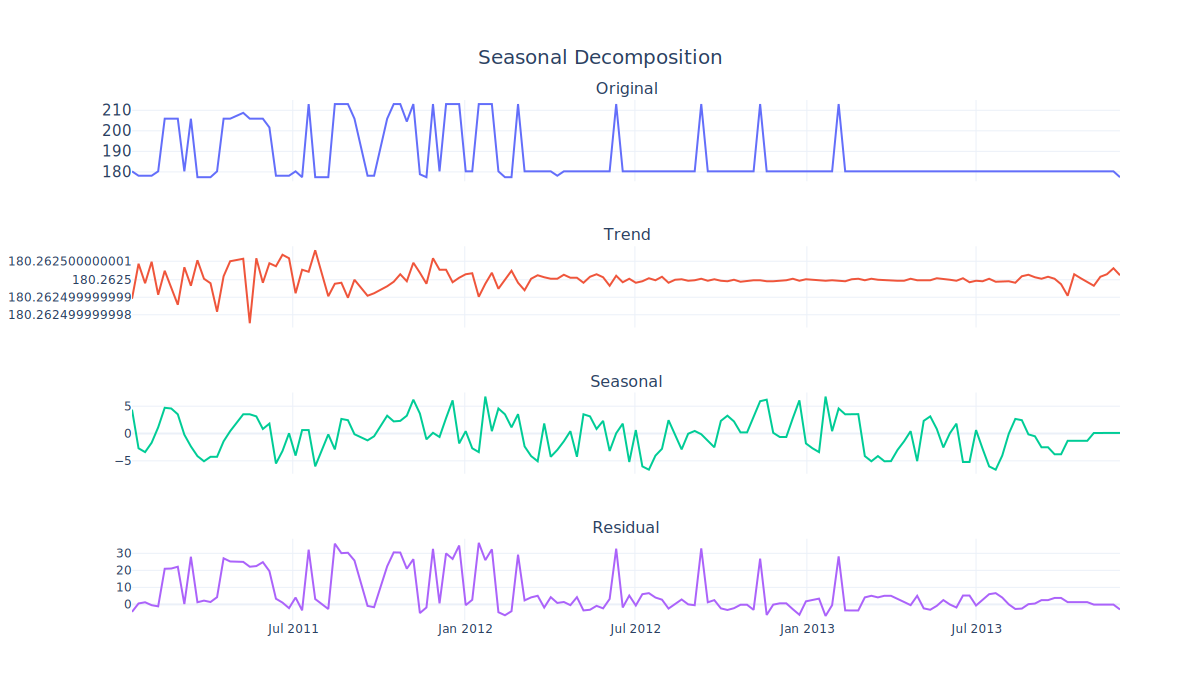

4

In [263]:
#Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:
#For first variable:
stl = FourierDecomposition(model = "additive", n_fourier_terms=10)
res_ts_9984_679023median_total_price = stl.fit(ts_9984_679023median_total_price, seasonality=seasonality)
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_parallel/multi_seasonal_decomposition_fit_'
file_edit = file
file_to_use = file_edit + '9984_679023median_total_price' + '.pik'
with open(file_to_use, 'wb') as f:
   pickle.dump(res_ts_9984_679023median_total_price, f) #write df to .pik file on disk
#Calculate seasonal period:
from matrixprofile import *
pattern = res_ts_9984_679023median_total_price.seasonal
pattern = pattern.to_numpy()
m = 5 #size of sub-sequences to compare for conserved features
mp = matrixProfile.stomp(pattern, m)
for ele in range(len(list(mp[1]))):
    if mp[1][ele] == float('inf'):
        #https://www.geeksforgeeks.org/python-infinity/https://codedamn.com/news/python/how-to-represent-infinity-in-python#
        #Accessed 14/06/2024
        mp[1][ele] = 0
mtfs , motif_d  = motifs.motifs(pattern, mp, max_motifs=10)
#mtfs = list of lists where each list is a motif with the indices of where each instance of the motif begins
#motif_d = how conserved each motif is
dist_lists_list = []
for ele in range(len(mtfs)):
    if len(mtfs[ele]) >= 3: #need two complete cycles for imputation = 3 indices of conserved features from the repeating motif
        motif = motif_d.index(min(motif_d[:(ele + 1)])) #best motif_d = most conserved
        dist_list = []
        for instance in range(len(mtfs[motif]) - 1):
            inst_current = mtfs[motif][instance]
            inst_next = mtfs[motif][instance + 1]
            dist_timestamps = inst_next - inst_current
            dist_list.append(dist_timestamps)
        import math
        seasonal_per = math.ceil(statistics.median(dist_list)) #(typical value as a measure of central tendency for a skewed or symmeteric 
        #(median = mean (1)) distribution):    
        #^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1
        #if median results in a .5 want higher val as for seasonal interpolation only integers allowed and better for pattern
        #to repeat too slow in model rather than overestimate for prices, featuring, units sold, displaying
        seasonal_period_list.append(seasonal_per)
    else:
        seasonal_period_list.append('not seasonal')
#^https://stackoverflow.com/questions/49873443/repeated-patterns-in-time-series-graphs - learned of Matrix Profile method
#Accessed 14/06/2024
#^http://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf - understood principles of Matrix Profile method
#Accessed 14/06/2024
#^http://www.cs.ucr.edu/~eamonn/MatrixProfile.html - found link to python package implementing Matrix Profile method, matrixprofile-ts
#Accessed 14/06/2024
#^https://github.com/target/matrixprofile-ts/blob/master/docs/examples/Motif%20Discovery.ipynb , https://github.com/target/matrixprofile-ts/blob/master/matrixprofile/matrixProfile.py
#Found source code and adapted it for calculating seasonal period from identified motifs
#Accessed 14/06/2024
#Find unique seasons:
entry_list = seasonal_period_list
found_list = []
unique_list = []
entry = []
entry_list_length = len(seasonal_period_list)
for i in range(entry_list_length):
    entry = entry_list[i]
    if entry not in found_list:
        unique_list.append(entry)
        found_list.append(entry)
unique_list
loopcount = len(unique_list)
i = 0
while i < loopcount:
    #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
    #Accessed 03/06/2024
    var = unique_list[i]
    if isinstance(var, str) == True:
        #^https://pythonprinciples.com/blog/check-if-var-is-string/
        #Accessed 14/06/2024
        unique_list.remove(unique_list[i])
        loopcount = int(loopcount - 1)
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024
    i += 1
    #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
    #Accessed 03/06/2024  
if not unique_list:
    seasonal_per = 'not seasonal'
#^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
#Accessed 14/06/2024
else:
    for item in range(len(unique_list)):
        if unique_list[item] > (len(ts_df)/2): #need min observations for 2 cycles of the season to be valid
            del unique_list[item]
            #^https://note.nkmk.me/en/python-list-clear-pop-remove-del/#remove-items-by-index-or-slice-del
            #Accessed 23/06/2024
    if not unique_list:
        seasonal_per = 'not seasonal'
        #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
        #Accessed 14/06/2024
    else:
         seasonal_per = min(unique_list, key=lambda x: abs(x - 52))
        #^https://medium.com/devcodef1com/match-lists-based-on-the-closest-value-in-python-5a0234548188#:~:text=Approach%202%3A%20Using%20the%20min()%20Function&text=The%20lambda%20function%20calculates%20the,which%20is%20the%20closest%20value.
        #Accessed 29/06/2024
        #knowing variables aggregated by median for all products and stores that are seasonal have seasonal period of 52, 
        #choose season closest to 52 - interpolator function as defined from source code can only take a single integer seasonal period argument, see below
#- https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/495cd6275ca3f3fd9951348d63fc0020a0f43636/src/imputation/interpolation.py

#Plot:
fig = res_ts_679023median_total_price.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/multi_seasonal_decomposition_9984_679023median_total_price.png")
fig.show(renderer="svg")
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
#Accessed 06/06/2024
seasonal_per

Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model for all variables:

In [264]:
seasonal_period_list = []

In [265]:
#Plot multi-seasonal decomposition using Fourier Decomposition as a seasonal model:
import statistics
import time
start = time.time()
print('Start!')
# for var in range(1):
for var in range(len(col_list)):
    ts = globals()[("ts_" + str(col_list[var]))]
    ts = ts_df[col_list[var]]
    stl = FourierDecomposition(model = "additive", n_fourier_terms=10) 
    res_var = stl.fit(ts, seasonality=seasonality)
    file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_parallel/multi_seasonal_decomposition_fit_'
    file_edit = file
    file_to_use = file_edit + str(col_list[var]) + '.pik'
    with open(file_to_use, 'wb') as f:
       pickle.dump(res_var, f) #write df to .pik file on disk
    #Calculate seasonal period:
    from matrixprofile import *
    pattern = res_var.seasonal
    pattern = pattern.to_numpy()
    m = 5 #size of sub-sequences to compare for conserved features
    mp = matrixProfile.stomp(pattern, m)
    seasonal_periods_list = []
    for ele in range(len(list(mp[1]))):
        if mp[1][ele] == float('inf'):
            #https://www.geeksforgeeks.org/python-infinity/https://codedamn.com/news/python/how-to-represent-infinity-in-python#
            #Accessed 14/06/2024
            mp[1][ele] = 0
    mtfs , motif_d  = motifs.motifs(pattern, mp, max_motifs=10)
    #mtfs = list of lists where each list is a motif with the indices of where each instance of the motif begins
    #motif_d = how conserved each motif is
    for ele in range(len(mtfs)):
        if len(mtfs[ele]) >= 3: #need two complete cycles for imputation = 3 indices of conserved features from the repeating motif
            motif = motif_d.index(min(motif_d[:(ele + 1)])) #best motif_d = most conserved
            dist_list = []
            for instance in range(len(mtfs[motif]) - 1):
                inst_current = mtfs[motif][instance]
                inst_next = mtfs[motif][instance + 1]
                dist_timestamps = inst_next - inst_current
                dist_list.append(dist_timestamps)
            import math
            seasonal_per = math.ceil(statistics.median(dist_list)) #(typical value as a measure of central tendency for a skewed or symmeteric 
            #(median = mean (1)) distribution):    
            #^(1) - https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1
            #if median results in a .5 want higher val as for seasonal interpolation only integers allowed and better for pattern
            #to repeat too slow in model rather than overestimate for prices, featuring, units sold, displaying
            seasonal_periods_list.append(seasonal_per)
        else:
            seasonal_periods_list.append('not seasonal')
    #^https://stackoverflow.com/questions/49873443/repeated-patterns-in-time-series-graphs - learned of Matrix Profile method
    #Accessed 14/06/2024
    #^http://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf - understood principles of Matrix Profile method
    #Accessed 14/06/2024
    #^http://www.cs.ucr.edu/~eamonn/MatrixProfile.html - found link to python package implementing Matrix Profile method, matrixprofile-ts
    #Accessed 14/06/2024
    #^https://github.com/target/matrixprofile-ts/blob/master/docs/examples/Motif%20Discovery.ipynb , https://github.com/target/matrixprofile-ts/blob/master/matrixprofile/matrixProfile.py
    #Found source code and adapted it for calculating seasonal period from identified motifs
    #Accessed 14/06/2024
    #Find unique seasons:
    entry_list = seasonal_periods_list
    found_list = []
    unique_list = []
    entry = []
    entry_list_length = len(seasonal_periods_list)
    for i in range(entry_list_length):
        entry = entry_list[i]
        if entry not in found_list:
            unique_list.append(entry)
            found_list.append(entry)
    unique_list
    loopcount = len(unique_list)
    i = 0
    while i < loopcount:
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024
        entry_2 = unique_list[i]
        if isinstance(entry_2, str) == True:
            #^https://pythonprinciples.com/blog/check-if-var-is-string/
            #Accessed 14/06/2024
            unique_list.remove(unique_list[i])
            loopcount = int(loopcount - 1)
            #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
            #Accessed 03/06/2024
        i += 1
        #^https://stackoverflow.com/questions/11905606/changing-the-number-of-iterations-in-a-for-loop
        #Accessed 03/06/2024  
    if not unique_list:
        seasonal_per = 'not seasonal'
    #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
    #Accessed 14/06/2024
    else:
        for item in range(len(unique_list)):
            if unique_list[item] > (len(ts_df)/2): #need min observations for 2 cycles of the season to be valid
                del unique_list[item]
                #^https://note.nkmk.me/en/python-list-clear-pop-remove-del/#remove-items-by-index-or-slice-del
                #Accessed 23/06/2024
        if not unique_list:
            seasonal_per = 'not seasonal'
            #^https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty
            #Accessed 14/06/2024
        else:
             seasonal_per = min(unique_list, key=lambda x: abs(x - 52))
        #^https://medium.com/devcodef1com/match-lists-based-on-the-closest-value-in-python-5a0234548188#:~:text=Approach%202%3A%20Using%20the%20min()%20Function&text=The%20lambda%20function%20calculates%20the,which%20is%20the%20closest%20value.
        #Accessed 29/06/2024
        #knowing variables aggregated by median for all products and stores that are seasonal have seasonal period of 52, 
        #choose season closest to 52 - interpolator function as defined from source code can only take a single integer seasonal period argument, see below
    #- https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/495cd6275ca3f3fd9951348d63fc0020a0f43636/src/imputation/interpolation.py

    seasonal_period_list.append(seasonal_per)
    
    fig = res_var.plot(interactive=True)
    fig.update_layout(
                legend=dict(
                    font=dict(size=15),
                    orientation="h",
                    yanchor="bottom",
                    y=0.98,
                    xanchor="right",
                    x=1,
                ),
                yaxis=dict(
                    # title_text=ylabel,
                    titlefont=dict(size=15),
                    tickfont=dict(size=15),
                ),
                xaxis=dict(
                    # title_text=xlabel,
                    titlefont=dict(size=15),
                    tickfont=dict(size=15),
                )
            )
    #^https://www.datacamp.com/tutorial/python-append-string#
    #Accessed 12/06/2024
    file_2 = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/decompositions_parallel/multi_seasonal_decomposition_'
    file_edit_2 = file_2
    file_to_use_2 = file_edit_2 + str(col_list[var]) + '.png'
    fig.write_image(file_to_use_2)
    #^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/02-Decomposing%20Time%20Series.ipynb
    #Accessed 06/06/2024
end = time.time()
print('secs: ', end - start) # time in seconds
print('min: ', (end - start)/60) # time in min

Start!


/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning:

invalid value encountered in divide



secs:  18.66867709159851
min:  0.3111446181933085


In [266]:
seasonal_period_list_init

['not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 'not 

In [267]:
seasonal_period_list

[4,
 'not seasonal',
 'not seasonal',
 52,
 52,
 'not seasonal',
 'not seasonal',
 52,
 'not seasonal',
 52,
 4,
 4,
 4,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 4,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 4,
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 4,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 4,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 4,
 4,
 'not seasonal',
 4,
 52,
 52,
 4,
 52,
 52,
 4,
 'not seasonal',
 52,
 'not seasonal',
 52,
 52,
 52,
 52,
 52,
 'not seasonal',
 52,
 52,
 4,
 'not seasonal',
 52,
 52,
 52,
 'not seasonal',
 'not seasonal',
 'not seasonal',
 52,
 52,
 52,
 52,
 'not seasonal',
 4,
 52,
 52,
 'not seasonal',
 52,
 4,
 52,
 'not seasonal',
 52,
 'not seasonal',
 'not seasonal',
 4,
 52,
 'not seasonal',

Pickle list:

In [268]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_variable_seasonal_period_list_parallel_2.pik'
with open(file, 'wb') as f:
    pickle.dump(seasonal_period_list, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      seasonal_period_list = pickle.load(f) #load pickle file 'file' into variable

In [269]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_variable_seasonal_period_list_parallel_3.pik'
with open(file, 'wb') as f:
    pickle.dump(seasonal_period_list, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      seasonal_period_list = pickle.load(f) #load pickle file 'file' into variable

In [270]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_variable_seasonal_period_list_init_parallel.pik'
with open(file, 'wb') as f:
    pickle.dump(seasonal_period_list_init, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      seasonal_period_list_init = pickle.load(f) #load pickle file 'file' into variable

Pickle imputed data:

In [271]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_imputed_df_pre_outliers_correct_parallel_2.pik'
with open(file, 'wb') as f:
    pickle.dump(ts_df, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      ts_df = pickle.load(f) #load pickle file 'file' into variable

In [272]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/janatahack_demand_forecasting_data_imputed_df_pre_outliers_correct_parallel_3.pik'
with open(file, 'wb') as f:
    pickle.dump(ts_df, f) #write df to .pik file on disk
# with open(file, 'rb') as f:
#      ts_df = pickle.load(f) #load pickle file 'file' into variable